# ScBasset: Analyzing scATACseq data

<div class="alert alert-warning">

Warning

SCBASSET's development is still in progress. The current version may not fully reproduce the original implementation's results.

</div>

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [ ]:
import matplotlib.pyplot as plt
import muon
import numpy as np
import scanpy as sc
import scvi
import seaborn as sns

In [1]:
scvi.settings.seed = 0

sc.set_figure_params(figsize=(4, 4), frameon=False)

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0
Global seed set to 0


## Loading data and preprocessing

Throughout this tutorial, we use [sample multiome data from 10X of 10K PBMCs](https://www.10xgenomics.com/resources/datasets/10-k-human-pbm-cs-multiome-v-1-0-chromium-x-1-standard-2-0-0).

In [2]:
url = "https://cf.10xgenomics.com/samples/cell-arc/2.0.0/10k_PBMC_Multiome_nextgem_Chromium_X/10k_PBMC_Multiome_nextgem_Chromium_X_filtered_feature_bc_matrix.h5"
mdata = muon.read_10x_h5("data/multiome10k.h5mu", backup_url=url)

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from data/multiome10k.h5mu


/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/mudata/_core/mudata.py:446: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/mudata/_core/mudata.py:671: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/mudata/_core/mudata.py:671: FutureWarning: In a future version, `df.iloc[:, i] = newvals`

In [3]:
mdata

MuData object with n_obs × n_vars = 10970 × 148344
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	10970 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	10970 x 111743
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

In [4]:
adata = mdata.mod["atac"]

We can use scanpy functions to handle, filter, and manipulate the data. In our case, we might want to filter out peaks that are rarely detected, to make the model train faster:

In [5]:
print(adata.shape)
# compute the threshold: 5% of the cells
min_cells = int(adata.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(adata, min_cells=min_cells)
print(adata.shape)

(10970, 111743)
(10970, 37054)


In [6]:
adata.var

,gene_ids,feature_types,genome,interval,n_cells
chr1:629395-630394,chr1:629395-630394,Peaks,GRCh38,chr1:629395-630394,1422
chr1:633578-634591,chr1:633578-634591,Peaks,GRCh38,chr1:633578-634591,4536
chr1:778283-779200,chr1:778283-779200,Peaks,GRCh38,chr1:778283-779200,5981
chr1:816873-817775,chr1:816873-817775,Peaks,GRCh38,chr1:816873-817775,564
chr1:827067-827949,chr1:827067-827949,Peaks,GRCh38,chr1:827067-827949,3150
...,...,...,...,...,...
GL000219.1:44739-45583,GL000219.1:44739-45583,Peaks,GRCh38,GL000219.1:44739-45583,781
GL000219.1:45726-46446,GL000219.1:45726-46446,Peaks,GRCh38,GL000219.1:45726-46446,639
GL000219.1:99267-100169,GL000219.1:99267-100169,Peaks,GRCh38,GL000219.1:99267-100169,6830
KI270726.1:41483-42332,KI270726.1:41483-42332,Peaks,GRCh38,KI270726.1:41483-42332,605


In [7]:
split_interval = adata.var["gene_ids"].str.split(":", expand=True)
adata.var["chr"] = split_interval[0]
split_start_end = split_interval[1].str.split("-", expand=True)
adata.var["start"] = split_start_end[0].astype(int)
adata.var["end"] = split_start_end[1].astype(int)
adata.var

,gene_ids,feature_types,genome,interval,n_cells,chr,start,end
chr1:629395-630394,chr1:629395-630394,Peaks,GRCh38,chr1:629395-630394,1422,chr1,629395,630394
chr1:633578-634591,chr1:633578-634591,Peaks,GRCh38,chr1:633578-634591,4536,chr1,633578,634591
chr1:778283-779200,chr1:778283-779200,Peaks,GRCh38,chr1:778283-779200,5981,chr1,778283,779200
chr1:816873-817775,chr1:816873-817775,Peaks,GRCh38,chr1:816873-817775,564,chr1,816873,817775
chr1:827067-827949,chr1:827067-827949,Peaks,GRCh38,chr1:827067-827949,3150,chr1,827067,827949
...,...,...,...,...,...,...,...,...
GL000219.1:44739-45583,GL000219.1:44739-45583,Peaks,GRCh38,GL000219.1:44739-45583,781,GL000219.1,44739,45583
GL000219.1:45726-46446,GL000219.1:45726-46446,Peaks,GRCh38,GL000219.1:45726-46446,639,GL000219.1,45726,46446
GL000219.1:99267-100169,GL000219.1:99267-100169,Peaks,GRCh38,GL000219.1:99267-100169,6830,GL000219.1,99267,100169
KI270726.1:41483-42332,KI270726.1:41483-42332,Peaks,GRCh38,KI270726.1:41483-42332,605,KI270726.1,41483,42332


In [8]:
# Filter out non-chromosomal regions
mask = adata.var["chr"].str.startswith("chr")
adata = adata[:, mask].copy()

In [9]:
scvi.data.add_dna_sequence(
    adata, chr_var_key="chr", start_var_key="start", end_var_key="end"
)
adata

15:18:25 | INFO | Downloading genome from UCSC. Target URL: http://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz...


Download:   0%|          | 0.00/938M [00:00<?, ?B/s]

15:18:34 | INFO | Genome download successful, starting post processing...
15:18:44 | INFO | name: hg38
15:18:44 | INFO | local name: hg38
15:18:44 | INFO | fasta: /tmp/tmp7jv_xk67/hg38/hg38.fa


Filtering Fasta: 0.00 lines [00:00, ? lines/s]

Working...: 100%|██████████| 24/24 [00:04<00:00,  5.48it/s]


AnnData object with n_obs × n_vars = 10970 × 37042
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells', 'chr', 'start', 'end'
    varm: 'dna_sequence', 'dna_code'

In [10]:
adata.varm["dna_sequence"]

,0,1,2,3,4,5,6,7,8,9,...,1324,1325,1326,1327,1328,1329,1330,1331,1332,1333
chr1:629395-630394,T,C,C,C,C,T,G,A,A,C,...,A,C,T,C,C,C,T,A,T,A
chr1:633578-634591,A,G,G,G,C,C,C,G,T,A,...,C,C,C,G,C,T,A,A,A,T
chr1:778283-779200,G,G,C,T,A,A,T,T,T,T,...,A,C,G,A,G,G,A,C,A,G
chr1:816873-817775,A,T,A,T,G,G,A,A,T,G,...,A,G,G,T,T,T,T,A,G,C
chr1:827067-827949,C,T,G,C,C,C,C,A,C,C,...,T,A,C,T,T,C,G,T,T,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrY:19077075-19078016,C,T,C,C,C,C,G,A,G,C,...,T,T,T,T,T,C,A,T,A,G
chrY:19567013-19567787,C,T,G,G,G,T,C,G,G,T,...,C,T,C,T,C,T,C,T,C,T
chrY:19744368-19745303,T,T,G,T,C,C,C,T,A,C,...,T,T,T,T,G,A,T,G,T,G
chrY:20575244-20576162,T,G,T,C,T,A,C,T,T,T,...,T,T,A,T,A,G,A,G,T,G


## Creating and training the model

We can now set up the AnnData object, which will ensure everything the model needs is in place for training.

This is also the stage where we can condition the model on additional covariates, which encourages the model to remove the impact of those covariates from the learned latent space. Our sample data is a single batch, so we won't demonstrate this directly, but it can be done simply by setting the `batch_key` argument to the annotation to be used as a batch covariate (must be a valid key in `adata.obs`) .

In [11]:
bdata = adata.transpose()
bdata.layers["binary"] = (bdata.X.copy() > 0).astype(float)
scvi.external.SCBASSET.setup_anndata(bdata, layer="binary", dna_code_key="dna_code")

INFO     Using column names from columns of adata.obsm['dna_code']                                                 


We can now create a PeakVI model object and train it!

**Importantly**: the default max epochs is set to 500, but in practice PeakVI stops early once the model converges, which rarely requires that many, especially for large datasets (which require fewer epochs to converge, since each epoch includes letting the model view more data).
*So the estimated runtime is usually a substantial overestimate of the actual runtime.*
In the case of the data we use for this tutorial, it used less than half of the max epochs!

In [12]:
bas = scvi.external.SCBASSET(bdata)
bas.train()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 717/1000:  72%|███████▏  | 717/1000 [1:36:30<38:05,  8.08s/it, loss=0.362, v_num=1]  
Monitored metric auroc_train did not improve in the last 45 records. Best score: 0.846. Signaling Trainer to stop.


<AxesSubplot: xlabel='epoch'>

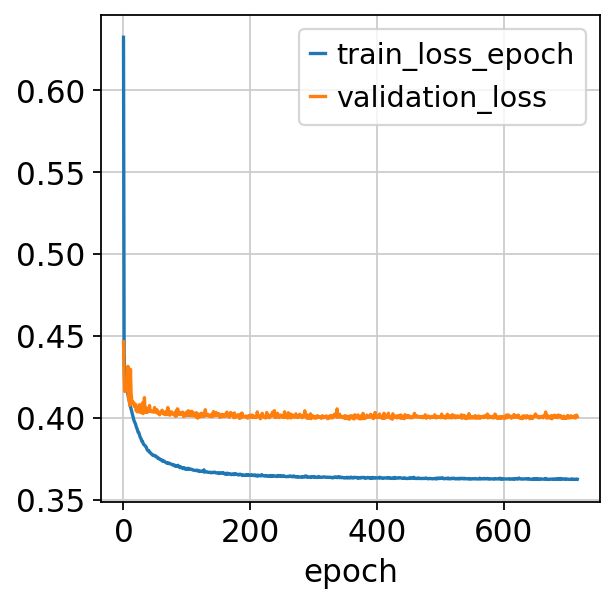

In [13]:
fig, ax = plt.subplots()
bas.history_["train_loss_epoch"].plot(ax=ax)
bas.history_["validation_loss"].plot(ax=ax)

<AxesSubplot: xlabel='epoch'>

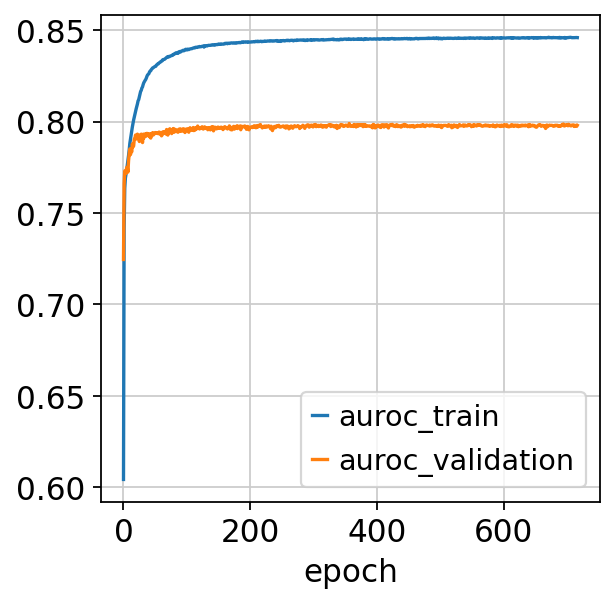

In [20]:
fig, ax = plt.subplots()
bas.history_["auroc_train"].plot(ax=ax)
bas.history_["auroc_validation"].plot(ax=ax)

## Visualizing and analyzing the latent space

We can now use the trained model to visualize, cluster, and analyze the data. We first extract the latent representation from the model, and save it back into our AnnData object:

In [14]:
latent = bas.get_latent_representation()
adata.obsm["X_scbasset"] = latent

print(latent.shape)

(10970, 32)


Text(0, 0.5, 'log10(UMI count)')

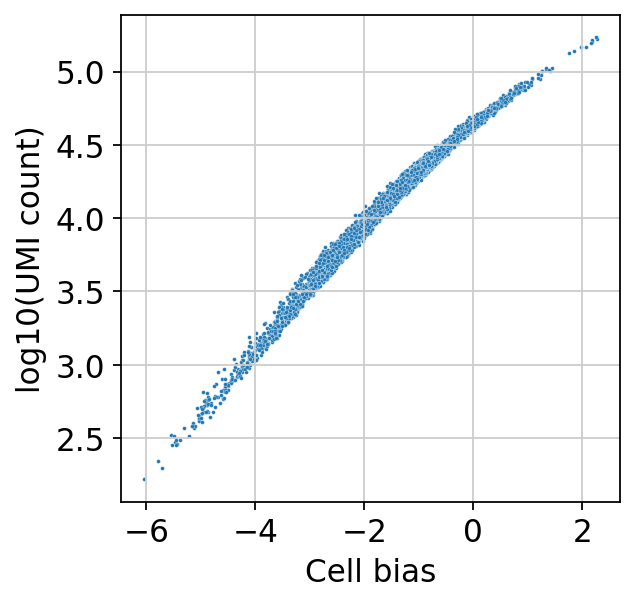

In [16]:
sns.scatterplot(
    x=bas.get_cell_bias(),
    y=np.log10(np.asarray(adata.X.sum(1))).ravel(),
    s=3,
)
plt.xlabel("Cell bias")
plt.ylabel("log10(UMI count)")

We can now use scanpy functions to cluster and visualize our latent space:

In [17]:
# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(adata, use_rep="X_scbasset")
# compute the umap
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden_scbasset")

/home/adam/miniconda3/envs/scvi-tools-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


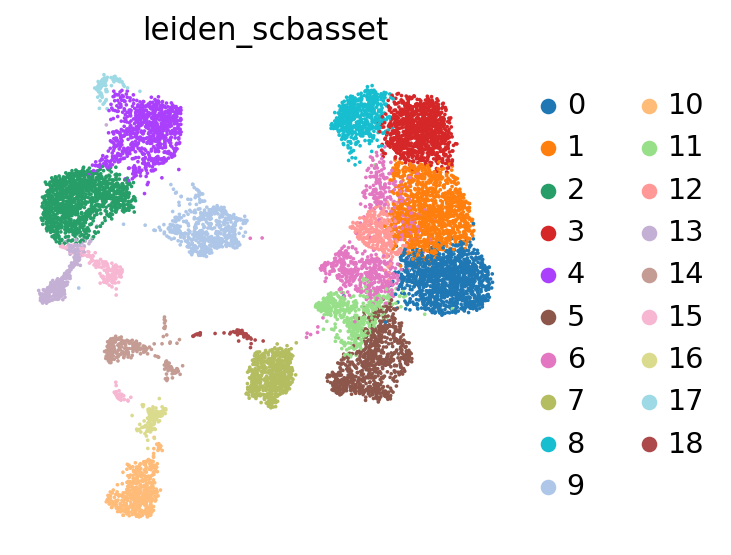

In [18]:
sc.pl.umap(adata, color="leiden_scbasset")